### Week 10 - text style transfer

Hello, sitzen class A.412C!

Based on your browser search history, we conclude that you have an above average skill in natural language processing. In our benevolence, we give you a chance to contribute your skills to upholding the happiest society in the universe. Are you up to the task?

As you know, our most recent breakthrough was replacing 97% restaurant workers with BFGHQBERT+++ autonomous food dispensers.

Yet a some radical elements failed to recognize the greater good that we brought them. They mistakenly voice their ignorant opinions about our new INGSOC-approved restaurants, brining dangerous doubt to the minds of our loyal citzens.

Surely you cannot tolerate such infidelity! Our loyal citzens demand that you rectify their mistake. _You must build a model that will automatically improve their ignorant thoughts and replace them with the thoughts they should actually have._

Attached below are the INGSOC-approved datasets for ignorant and correct thoughts. The scientific terminology is for wrong opinions and correct opinions is "negative" and "positive", respectively.

Respond within 7 days or you will lose 3.7629 citzenship points.

![img](https://ih1.redbubble.net/image.1254830934.9884/poster,504x498,f8f8f8-pad,400x240,f8f8f8.jpg)

In [597]:
!which python

/home/iris/paulshab/NLP_env/nlp_environ/bin/python


In [2]:
# !pip install -q transformers
# !wget -q https://github.com/shentianxiao/language-style-transfer/raw/master/data/yelp/sentiment.train.0 -O train_negative
# !wget -q https://github.com/shentianxiao/language-style-transfer/raw/master/data/yelp/sentiment.train.1 -O train_positive
# !wget -q https://github.com/shentianxiao/language-style-transfer/raw/master/data/yelp/sentiment.dev.0 -O dev_negative
# !wget -q https://github.com/shentianxiao/language-style-transfer/raw/master/data/yelp/sentiment.dev.1 -O dev_positive

In [3]:
!head -n 5 ./dev_positive
!echo
!head -n 5 ./dev_negative

staff behind the deli counter were super nice and efficient !
love this place !
the staff are always very nice and helpful .
the new yorker was amazing .
very ny style italian deli .

ok never going back to this place again .
easter day nothing open , heard about this place figured it would ok .
the host that walked us to the table and left without a word .
it just gets worse .
the food tasted awful .


In [1]:
import typing as tp
import numpy as np
import pandas as pd
import os

from collections import defaultdict
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

if device == 'cpu':
    print("Fine-tuning BERT without an accelerator is not party-approved.")

pd.set_option('display.max_colwidth', -1)  

/home/iris/paulshab/NLP_env/nlp_environ/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### Part 1: Masked language model

Attached below you can find the INGSOC-compliant training code that fine-tunes a BERT model for Masked Language Modeling.

You shall use this model to generate positive replacements for negative tokens.

In [2]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_mlm_positive = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True).to(device).train(True)

In [21]:
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

# print("Preparing the training data...")
# positive_dataset = LineByLineTextDataset(
#     file_path="./train_positive", tokenizer=tokenizer, block_size=128 )

# negative_dataset = LineByLineTextDataset(
#     file_path="./train_negative", tokenizer=tokenizer, block_size=128)

# print("Dataset ready!")

# trainer = Trainer(
#     model=bert_mlm_positive, train_dataset=dataset, 
#     data_collator=DataCollatorForLanguageModeling(
#         tokenizer=tokenizer, mlm=True, mlm_probability=0.15),
#     args=TrainingArguments(
#         output_dir="./bert_mlm_positive", overwrite_output_dir=True,
#         num_train_epochs=1, per_device_train_batch_size=32,
#         save_steps=10_000, save_total_limit=2),
# )

# trainer.train()

Preparing the training data...


/home/iris/paulshab/NLP_env/nlp_environ/lib/python3.7/site-packages/transformers/data/datasets/language_modeling.py:124: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


Dataset ready!


In [5]:
# Get Lines

with open('train_negative', encoding="utf-8") as f:
    negative_lines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]
    
with open('train_positive', encoding="utf-8") as f:
    positive_lines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]
    
print(len(negative_lines))
print(len(positive_lines))

# Get Datatset

negative_dataset = Dataset(tokenizer, negative_lines)
positive_dataset = Dataset(tokenizer, positive_lines)

# Get TrainLoaders

positive_loader = torch.utils.data.DataLoader(positive_dataset, 
                                               batch_size=32, 
                                               drop_last= True, 
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'], device='cuda:0'
                                                                          ))

negative_loader = torch.utils.data.DataLoader(negative_dataset, 
                                              batch_size=32, 
                                              drop_last= True, 
                                              collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'], device='cuda:0'
                                                                          ))

negative_batch = next(iter(negative_loader))
print(negative_batch['text'][5])

positive_batch = next(iter(positive_loader))
print(positive_batch['text'][3])

176787
267314
i had to pay $ _num_ to add cheese to the hoagie .
it 's a good toasted hoagie .


In [8]:
negative_lines

['i was sadly mistaken .',
 'so on to the hoagies , the italian is general run of the mill .',
 'minimal meat and a ton of shredded lettuce .',
 'nothing really special & not worthy of the $ _num_ price tag .',
 'second , the steak hoagie , it is atrocious .',
 'i had to pay $ _num_ to add cheese to the hoagie .',
 'she told me there was a charge for the dressing on the side .',
 'are you kidding me ?',
 'i was not going to pay for the dressing on the side .',
 'i ordered it without lettuce , tomato , onions , or dressing .',
 'are you kidding me ?',
 'i paid $ _num_ to add sauted mushrooms , onions , and cheese .',
 'in this case , never .',
 '( the hoagie bun was better than average . )',
 'wake up or you are going to lose your business .',
 'this place has none of them .',
 'it is april and there are no grass tees yet .',
 'there is no grass on the range .',
 'bottom line , this place sucks .',
 'someone should buy this place and turn it into what it should be .',
 'very disappointe

In [7]:
negative_dataset[0]

{'input_ids': tensor([  101,  1045,  2001, 13718, 13534,  1012,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1]), 'text': 'i was sadly mistaken .'}

### Helper Functions

In [4]:
def convergence_graph(loss_vals):
    print("min loss value", loss_vals[-1])

    plt.plot(range(1, len(loss_vals) +1 ), loss_vals, color ='blue')
    plt.rcParams["figure.figsize"] = (10,6)
    plt.grid()
    plt.xlabel("Number of iterations")
    plt.ylabel("cost (J)")
    plt.title("Convergence of gradient descent")

def apply_mask(example: tp.Dict[str, tp.Any], device='cuda:0', percent=0.15):
    
    # copy real input_ids:
    example['labels'] = example['input_ids'].detach().clone()
    
    # create random array of floats in equal dimension to input_ids
    rand = torch.rand(example['input_ids'].shape).to(device)

    # where the random array is less than 0.15, we set true
    mask_arr = rand < percent *  (example['input_ids'] != 101) * (example['input_ids'] != 102) * (example['input_ids'] != 0) 
    
    # create selection from mask_arr
    selection = mask_arr.nonzero().tolist()

    for i, j in selection:
        example['input_ids'][i][j] = 103
        
    return example


class PadSequence:
    def __init__(self, padded_columns, device='cuda:1'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)
            
        #print("done")       
        for key, val in padded_batch.items():
            #print(val)
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch
    

class Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, lines):
        self.tokenizer = tokenizer
        self.lines = lines
       
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.lines)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        sample = self.tokenizer(self.lines[index])
        sample['input_ids'] = torch.as_tensor(sample['input_ids'])
        sample['token_type_ids'] = torch.tensor(sample['token_type_ids'])
        sample['attention_mask'] = torch.tensor(sample['attention_mask'])
        sample['text'] = self.lines[index]
        
        return sample
    

In [ ]:
def pretrain_masked_lm(model, loader, num_epochs=10, device='cuda:0'):
    model.to(device)
    model.train() 
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    train_loss = []
    avg_batch_loss = []
    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in loader:
            batch = apply_mask(batch)
            outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'], 
                        labels=batch['labels'].long(), 
                        output_hidden_states=True,
                        return_dict=True
                       )
            loss = outputs.loss
            #print(loss)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            avg_batch_loss.append(loss.item())
        
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        train_loss.append(avg)
        
    return train_loss

train_loss = pretrain_masked_lm(bert_mlm_positive, positive_loader)
convergence_graph(train_loss) 

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 6/10 [1:08:50<45:56, 689.22s/it]

### Load Bert_mlm_positive

In [342]:
bert_mlm_positive = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

bert_mlm_positive.load_state_dict(torch.load('weights/bert_positive.pth'))     

bert_mlm_positive.to('cuda:0')

print()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


min loss value 0.14208222125659914


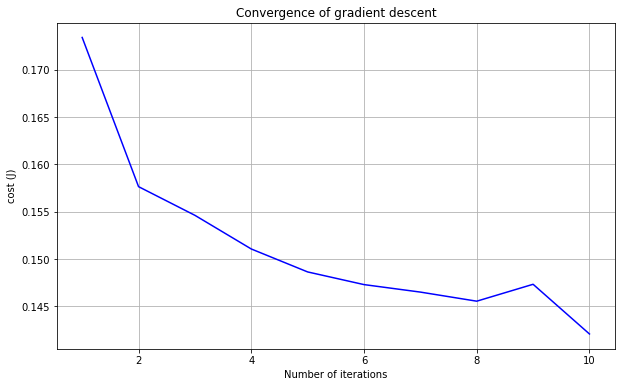

In [127]:
convergence_graph(train_loss) 

In [ ]:
torch.save(bert_mlm_positive.state_dict(), 'weights/bert_positive.pth')

In [ ]:
# <Build and train a MLM for incorrect opinions>

bert_mlm_negative = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True).to(device)

train_loss2 = pretrain_masked_lm(bert_mlm_negative, negative_loader, num_epochs=20)

torch.save(bert_mlm_negative.state_dict(), 'weights/bert_negative.pth')

convergence_graph(train_loss2) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 11/20 [1:28:52<1:12:47, 485.29s/it]

min loss value 0.15034109814420266


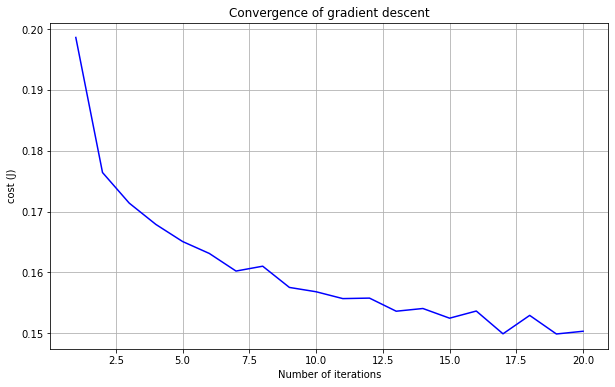

In [453]:
convergence_graph(train_loss2)  #  0.15683198736536813

### Load Bert_mlm_negative

In [352]:
#bert_mlm_negative = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

bert_mlm_negative.load_state_dict(torch.load('weights/bert_negative.pth'))     

bert_mlm_negative.to('cuda:0')

print()

### Part 2: Replace tokens

You can now use the two masked language models to align user opinions. You can do so with the following steps:

1. Find tokens where the ratio $(P_{positive}(x) + \epsilon) / (P_{negative}(x) + \epsilon)$ is the smallest
2. Replace those tokens with one of $k$ most likely tokens according to $P_{positive}(x)$.
3. Rinse, repeat

You can find the full procedure at https://arxiv.org/abs/2010.01054

In [1]:
"this food is bad"

'this food is bad'

In [607]:
from copy import deepcopy 
from transformers import pipeline
import random

def get_replacements(sentence: str, num_tokens, k_best, epsilon=1e-3, device='cuda:0'):
    
    bert_mlm_positive.to(device)
    bert_mlm_negative.to(device)
   
    bert_mlm_positive.eval()
    bert_mlm_negative.eval()
    
    """
    - split the sentence into tokens using the INGSOC-approved BERT tokenizer
    - find :num_tokens: tokens with the highest ratio (see above)
    - replace them with :k_best: words according to bert_mlm_positive
    :return: a list of all possible strings (up to k_best * num_tokens)
    """

    example = tokenizer(sentence, return_tensors='pt').to(device)
    sample_dict = {}
    for i in range(1, example['input_ids'].shape[1] - 1):
        masked_example = deepcopy(example)
        
        masked_example['input_ids'][0][i] = 103
        label = example['input_ids'][0][i].cpu()
        
        with torch.no_grad():
            positive_outputs = bert_mlm_positive(input_ids=masked_example['input_ids'],
                        attention_mask=masked_example['attention_mask'], 
                       ).logits.cpu()
            
            negative_outputs = bert_mlm_negative(input_ids=masked_example['input_ids'],
                                                 attention_mask=example['attention_mask'], 
                                                ).logits.cpu()
        
        #print("\n", tokenizer.decode(label))   
        positive_score = positive_outputs[0][i][label]
        
        negative_score = negative_outputs[0][i][label]
        
        score = (positive_score + epsilon) / (negative_score + epsilon)
        #print("score:", score, "\n")             
        sample_dict[label] = [score, i]
    
    
    score_dict = dict(sorted(sample_dict.items(), key=lambda item: item[1], reverse=False))  # sort dict
    #print(score_dict)
    
    token_dict = {}
    #token_list = list(score_dict)[: num_tokens]
    token_list = list(score_dict.items())[: num_tokens]
    
    with torch.no_grad():
        unmasker = pipeline('fill-mask', model=bert_mlm_positive.cpu(), tokenizer=tokenizer)
    
    #print(token_list)
    for token in token_list:
        modified = example['input_ids'].clone()
        #modified = torch.where(modified==token[0] ,torch.tensor(103).to(device),modified).cpu()
        modified[0][token[1][1]] = 103
        modified = list(modified[0])
        modified = tokenizer.decode(modified)
        new_sentences = unmasker(modified)[:k_best]
        for i in range(k_best):
            val_arr = []
            for i, val in enumerate(new_sentences):
                val_arr.append(val['token'])
            token_dict[token[0]] = val_arr
            
    #print(token_dict)
    
    modified = example['input_ids'].clone().cpu()
    for key in token_dict:
        elem = random.choice(token_dict[key])
        modified = torch.where(modified==key,torch.tensor(elem), modified).cpu()
    
    modified = list(modified[0])
    modified = tokenizer.decode(modified, skip_special_tokens=True) 
    
    return modified


get_replacements("food is bad and quite horrible.", 2, 3)
#get_replacements("the tables are all saved by people crowded around the two tvs .", num_tokens=4, k_best=1)
#get_replacements("this is very bad food", num_tokens=1, k_best=1)

'food is great and quite delicious.'

In [606]:
get_replacements("great wings and decent drinks but the wait staff is horrible !",
                 num_tokens=2, k_best=2)
# >>> ["great wings and decent drinks but the wait staff is great !", "great wings and decent drinks but the wait staff is awesome !"])


 g r e a t
score: tensor(1.3592) 


 w i n g s
score: tensor(1.0392) 


 a n d
score: tensor(0.9051) 


 d e c e n t
score: tensor(1.5033) 


 d r i n k s
score: tensor(1.3830) 


 b u t
score: tensor(0.5739) 


 t h e
score: tensor(1.0714) 


 w a i t
score: tensor(1.2563) 


 s t a f f
score: tensor(1.0368) 


 i s
score: tensor(0.9056) 


 h o r r i b l e
score: tensor(-0.0260) 


 !
score: tensor(1.0639) 



'great wings and decent drinks and the wait staff is friendly!'

__Final task__ - build a procedure that iteratively applies replacements, demonstrate the effectiveness of your approach with at least 10 examples to satisfy INGSOC.


In [487]:
dev_data = list(open('./dev_negative'))
dev_data[500:505]

In [596]:
df = pd.DataFrame(columns=['negative', 'positive']) 

for sample in dev_data[495:520]:
    num_tokens, k_best = 4, 1
#     if len(sample.split(' ')) < num_tokens:
#         num_tokens = len(sample.split(' ')) - 1
#         print(num_tokens, len(sample.split(' ')))
    text = get_replacements(sample, num_tokens=num_tokens, k_best=k_best)
    df = df.append({'negative': sample, 'positive':  text}, ignore_index=True)

df

,negative,positive
0,"you know , i used to really like this place .\n",you know what you seem to really like this place.
1,my previous review was _num_ stars .\n,this previous review was _ _m _ stars.
2,"johnny , the manager , told me that he would issue a gift certificate .\n","chris, service manager, told me that he would need a gift shop."
3,the subs are n't even what they used to be .\n,the subs aren't fit though i want to be.
4,"( unless you like soggy bread under your meatballs , of course . )\n","( unless you like the the and underrated meatballs, of course. )"
5,wrong !\n,amazing!
6,i 'm sure she wo n't issue a refund because - surprise !\n,i'm happy she won't get a refunder - wow!
7,nothing special and the drinks are n't cheap .\n,nothing special about the best aren't cheap.
8,great wings and decent drinks but the wait staff is horrible !\n,great wings and decent drinks and the wait staff is great!
9,the tables are all saved by people crowded around the two tvs .\n,with tables are all run by being looking around with two tvs.


### Part 3: Classifier & beam search (5 pts)

Sometimes the roots of dissent too deep to rip out with single word replacements. If you truly are a class A412C citzen, surely you understand what it means.

In order to better serve your fellow citzens, you must improve your solution. Train a classifier model that will separate the negative (ignorant) opinions from positive ones.

With this classifier you can now generate multiple best hypotheses and search for the ones that have the highest $P_{classifier}(\text{positive} | x)$.

In [ ]:
# tell apart positive from negative classifier

In [ ]:
from transformers import BertForSequenceClassification, DataCollatorWithPadding

<YOUR CODE HERE - build and train the classifier model>

In [ ]:
# your final task is to build a beam search-like procedure that iteratively
# generates candidates using MLM and selects M best with classifier

# as before, your fellow citzens request that you show your loyalty by 
# writing a short report on how your method works and demonstrating
# the effectiveness of your system works with at least 10 examples

# Note: as a class >=A410 citzen, you are entitled to creativity level 2.1:
# you may modify the search objective by using language models, different search procedures
# or implement a completely different style transfer method.

<OBEY HERE>